## Ignore Warnings

In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Import Libraries

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

import time
import platform 

## System Perference Checking

In [3]:
print(platform.machine())
print(platform.version())
print(platform.processor())

arm64
Darwin Kernel Version 22.3.0: Thu Jan  5 20:50:21 PST 2023; root:xnu-8792.81.2~2/RELEASE_ARM64_T8112
arm


## Splitting Dataset into 80-20 

In [4]:
batch_size = 32
img_height = 64
img_width = 64
data_dir = "processed/"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  shuffle = True, 
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
    color_mode='grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  shuffle = True, 
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
    color_mode='grayscale')

Found 15000 files belonging to 15 classes.
Using 12000 files for training.
Metal device set to: Apple M2


2023-02-06 18:43:14.056006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-06 18:43:14.056038: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 15000 files belonging to 15 classes.
Using 3000 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)
class_names = val_ds.class_names
print(class_names)

['0', '1', '10', '100', '1000', '10000', '100000000', '2', '3', '4', '5', '6', '7', '8', '9']
['0', '1', '10', '100', '1000', '10000', '100000000', '2', '3', '4', '5', '6', '7', '8', '9']


## Initial Examine of Our Dataset

2023-02-06 18:43:27.431048: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


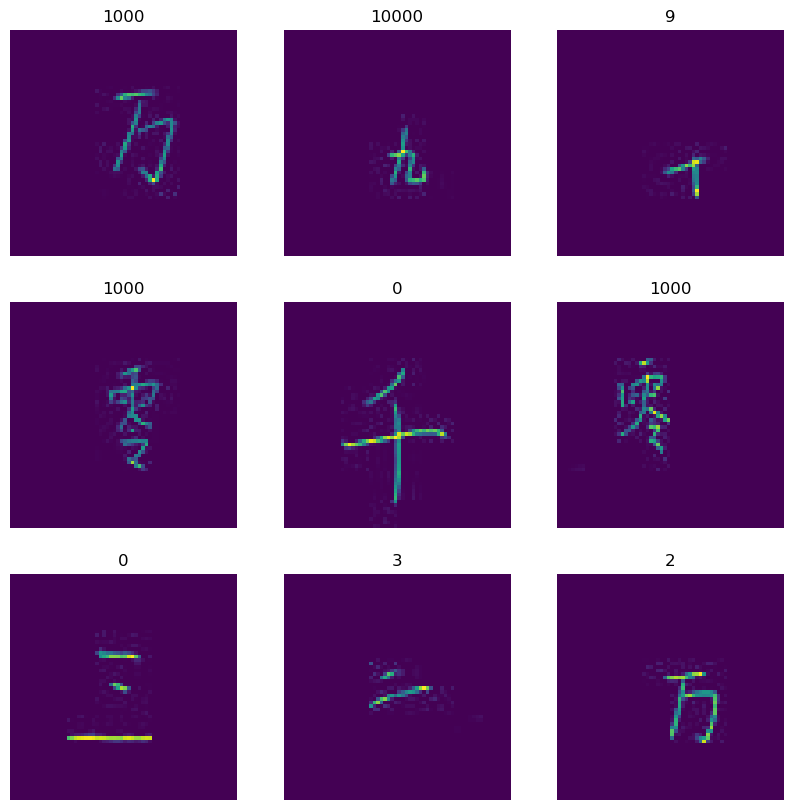

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i+1].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Simple Pre-processing

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
# 3 color channels RGB

(32, 64, 64, 1)
(32,)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.6627451


In [9]:
# Dataset performance configuration, keep images in memory after first ieration to avoid bottleneck
# overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## ResNet101

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

In [11]:
train_dataset = train_datagen.flow_from_directory(directory = data_dir,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = data_dir,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 12000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [12]:
base_model =tf.keras.applications.ResNet101(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

171446536/171446536 [==============================] - 17s 0us/step


In [13]:
for layer in base_model.layers:
    layer.trainable=False

In [14]:
num_classes = len(class_names)

model101=Sequential()
model101.add(base_model)
model101.add(Dropout(0.5))
model101.add(Flatten())
model101.add(BatchNormalization())
model101.add(Dense(64,kernel_initializer='he_uniform'))
model101.add(BatchNormalization())
model101.add(Activation('relu'))
model101.add(Dropout(0.5))
model101.add(Dense(64,kernel_initializer='he_uniform'))
model101.add(BatchNormalization())
model101.add(Activation('relu'))
model101.add(Dropout(0.5))
model101.add(Dense(32,kernel_initializer='he_uniform'))
model101.add(BatchNormalization())
model101.add(Activation('relu'))
model101.add(Dropout(0.5))
model101.add(Dense(32,kernel_initializer='he_uniform'))
model101.add(BatchNormalization())
model101.add(Activation('relu'))
model101.add(Dropout(0.5))
model101.add(Dense(32,kernel_initializer='he_uniform'))
model101.add(BatchNormalization())
model101.add(Activation('relu'))
model101.add(Dense(num_classes,activation='softmax'))

In [15]:
model101.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [16]:
model101.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [17]:
epoch = 10

history = model101.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=epoch)

Epoch 1/10


2023-02-06 18:45:23.856974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 18:45:30.585238: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x168f7d750
2023-02-06 18:45:30.585293: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x168f7d750
2023-02-06 18:45:30.631901: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x168f7d750
2023-02-06 18:45:30.763142: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x168f7d750
2023-02-06 18:45:31.045123: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_22' defined at (most recent call last):
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/q7/hl1q8nr10b3dpr7qbtpb57n80000gn/T/ipykernel_46682/197472587.py", line 3, in <module>
      history = model101.fit(
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/kimhoonglim/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_22'
could not find registered platform with id: 0x168f7d750
	 [[{{node StatefulPartitionedCall_22}}]] [Op:__inference_train_function_22712]

## Our first CNN model

In [9]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [10]:
model

In [25]:
from tensorflow.keras import backend as K

In [42]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision1 = precision(y_true, y_pred)
    recall1 = recall(y_true, y_pred)
    return 2*((precision1*recall1)/(precision1+recall1+K.epsilon()))

In [47]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy',f1_score, precision, recall])

In [49]:
epoch = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epoch)

Epoch 1/10
375/375 [==============================] - 47s 126ms/step - loss: 0.0116 - accuracy: 0.9965 - f1_score: 1.5381 - precision: 1.0000 - recall: 3.3433 - val_loss: 0.1293 - val_accuracy: 0.9690 - val_f1_score: 1.5012 - val_precision: 1.0000 - val_recall: 3.0191
Epoch 2/10
375/375 [==============================] - 47s 124ms/step - loss: 0.0153 - accuracy: 0.9957 - f1_score: 1.5210 - precision: 1.0000 - recall: 3.1863 - val_loss: 0.0957 - val_accuracy: 0.9807 - val_f1_score: 1.5172 - val_precision: 1.0000 - val_recall: 3.1516
Epoch 3/10
375/375 [==============================] - 46s 122ms/step - loss: 0.0115 - accuracy: 0.9967 - f1_score: 1.5283 - precision: 1.0000 - recall: 3.2541 - val_loss: 0.0952 - val_accuracy: 0.9817 - val_f1_score: 1.5419 - val_precision: 1.0000 - val_recall: 3.3726
Epoch 4/10
375/375 [==============================] - 43s 114ms/step - loss: 0.0028 - accuracy: 0.9998 - f1_score: 1.5188 - precision: 1.0000 - recall: 3.1653 - val_loss: 0.0727 - val_accuracy:

In [31]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 32)       

#### Explanation

We run 10 ephocs on the initial checking of the performance. As shown above, we potentially reached a maximum accuracy of 98.03% on the testing dataset without any data augmentation steps. 

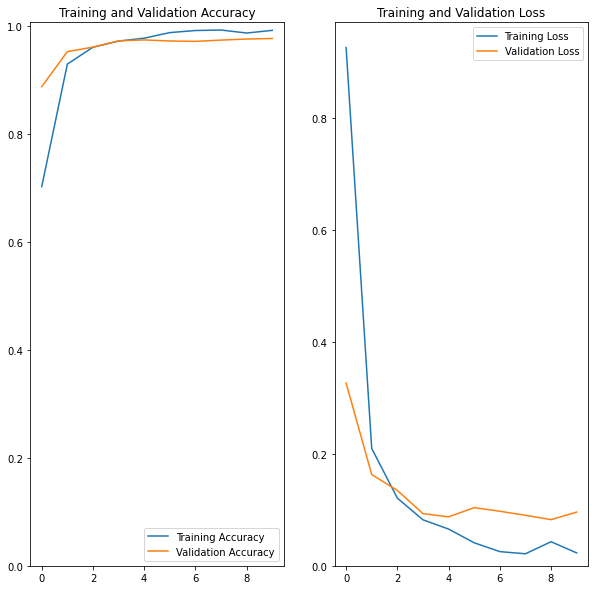

In [30]:
def plot_result(history,epochs):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.ylim(ymin=0) 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylim(ymin=0) 
    plt.show()

plot_result(history,epoch)

In [53]:
model.save('cmnist_model_6.h5')
print('saved')

saved


This image most likely belongs to 100000000 with a 100.00 percent confidence.


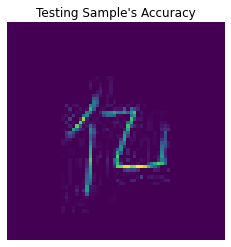

In [54]:
# Test the model
from PIL import Image

img = Image.open('data/c14.jpg')

plt.figure()
plt.imshow(img)
plt.title("Testing Sample's Accuracy")
plt.axis("off")
plt.show

img = img.resize((64, 64))
img = img.convert('L')

# Preprocessing the image
x = image.img_to_array(img)
# x = np.true_divide(x, 255)
x = np.expand_dims(x, axis=0)

model = load_model('cmnist_model_6.h5')    
preds = model.predict(x)
score = tf.nn.softmax(preds[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

## CNN with Data Augmentation 

In [55]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

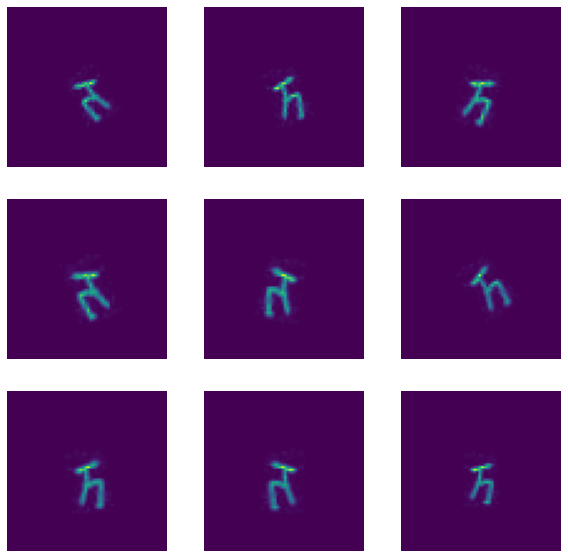

In [56]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [57]:
augmented_model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [58]:
augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
augmented_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 64, 64, 1)         0         
                                                                 
 rescaling_15 (Rescaling)    (None, 64, 64, 1)         0         
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                

In [60]:
epochs = 10
history1 = augmented_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
augmented_model.save('cmnist_model_7.h5')
print('saved')

Epoch 1/10
375/375 [==============================] - 49s 126ms/step - loss: 1.4547 - accuracy: 0.5093 - val_loss: 0.5198 - val_accuracy: 0.8180
Epoch 2/10
375/375 [==============================] - 50s 132ms/step - loss: 0.6555 - accuracy: 0.7779 - val_loss: 0.4322 - val_accuracy: 0.8480
Epoch 3/10
375/375 [==============================] - 45s 121ms/step - loss: 0.4879 - accuracy: 0.8378 - val_loss: 0.2337 - val_accuracy: 0.9203
Epoch 4/10
375/375 [==============================] - 48s 127ms/step - loss: 0.4068 - accuracy: 0.8619 - val_loss: 0.3193 - val_accuracy: 0.8873
Epoch 5/10
375/375 [==============================] - 51s 135ms/step - loss: 0.3292 - accuracy: 0.8847 - val_loss: 0.2028 - val_accuracy: 0.9263
Epoch 6/10
375/375 [==============================] - 54s 144ms/step - loss: 0.2914 - accuracy: 0.9041 - val_loss: 0.1716 - val_accuracy: 0.9407
Epoch 7/10
375/375 [==============================] - 55s 146ms/step - loss: 0.2639 - accuracy: 0.9132 - val_loss: 0.1709 - val_ac

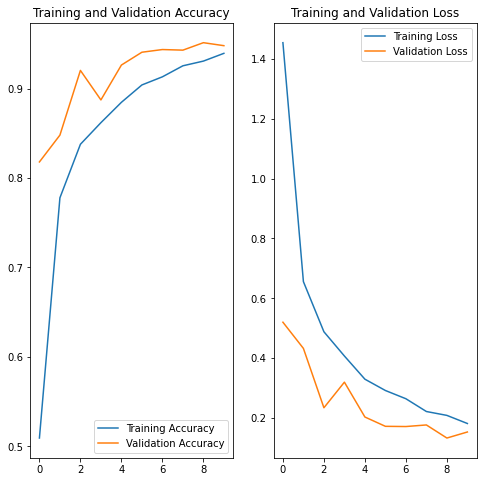

In [61]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to 8 with a 100.00 percent confidence.


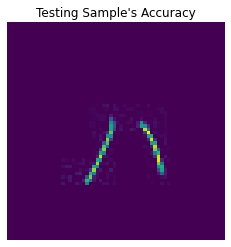

In [9]:
# Test the model
from PIL import Image

img = Image.open('data/n6.jpg')

plt.figure()
plt.imshow(img)
plt.title("Testing Sample's Accuracy")
plt.axis("off")
plt.show

img = img.resize((64, 64))
img = img.convert('L')

# Preprocessing the image
x = image.img_to_array(img)
# x = np.true_divide(x, 255)
x = np.expand_dims(x, axis=0)

model = load_model('cmnist_model_7.h5')    
preds = model.predict(x)
score = tf.nn.softmax(preds[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

In [11]:
from sklearn.metrics import precision_recall_fscore_support

## Testing other CNN archituecture as from Literature Review

In [86]:
num_classes = len(class_names)

testing_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(64,64,1)),  
  tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(), 
  
  tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"),
  tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),  
  tf.keras.layers.BatchNormalization(),
  
  tf.keras.layers.Conv2D(filters=256, kernel_size = (3,3), activation="relu"),  
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)), 
  tf.keras.layers.BatchNormalization(),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512,activation = "relu"),
  tf.keras.layers.Dense(num_classes,activation = "softmax")  
])

testing_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [87]:
testing_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 conv2d_61 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 30, 30, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_62 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 conv2d_63 (Conv2D)          (None, 26, 26, 128)     

In [ ]:
epoch = 10

testing_history = testing_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epoch)

Epoch 1/10


/Users/kimhoonglim/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


375/375 [==============================] - 405s 1s/step - loss: 0.4488 - accuracy: 0.8762 - val_loss: 0.1862 - val_accuracy: 0.9533
Epoch 2/10
375/375 [==============================] - 387s 1s/step - loss: 0.0904 - accuracy: 0.9736 - val_loss: 0.1379 - val_accuracy: 0.9597
Epoch 3/10
375/375 [==============================] - 387s 1s/step - loss: 0.0689 - accuracy: 0.9799 - val_loss: 0.1705 - val_accuracy: 0.9587
Epoch 4/10
375/375 [==============================] - 3641s 10s/step - loss: 0.0522 - accuracy: 0.9853 - val_loss: 0.1094 - val_accuracy: 0.9770
Epoch 5/10
375/375 [==============================] - 371s 990ms/step - loss: 0.0547 - accuracy: 0.9857 - val_loss: 0.2237 - val_accuracy: 0.9583
Epoch 6/10
125/375 [=========>....................] - ETA: 36:17:35 - loss: 0.0725 - accuracy: 0.9852